<a href="https://colab.research.google.com/github/ZzangJay/team_project/blob/kimjisan/20221112_code_js.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
#import tensorflow as tf 
import os
import sys
from datetime import datetime, timedelta
from tqdm.autonotebook import tqdm
import csv
import re
import gzip
import shutil

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [2]:
from google.colab import drive  # for colab
drive.mount('/content/gdrive/')  # for colab
cloud_directory = '/content/gdrive/MyDrive/mimiciv_unzip/'
os.listdir(cloud_directory) # for colab, check cloud directory mount

Mounted at /content/gdrive/


['CHANGELOG.txt',
 'LICENSE.txt',
 'SHA256SUMS.txt',
 'index.html',
 'icu',
 'hosp',
 'drop_2_chartevents.csv']

In [3]:
admission = pd.read_csv('/content/gdrive/MyDrive/mimiciv_unzip/hosp/admissions.csv', low_memory=False, dtype='str', keep_default_na=False)
patients = pd.read_csv('/content/gdrive/MyDrive/mimiciv_unzip/hosp/patients.csv', low_memory=False, dtype='str', keep_default_na=False)
diagnoses_icd = pd.read_csv('/content/gdrive/MyDrive/mimiciv_unzip/hosp/diagnoses_icd.csv', low_memory=False, dtype='str', keep_default_na=False)
icustays = pd.read_csv('/content/gdrive/MyDrive/mimiciv_unzip/icu/icustays.csv', low_memory=False, dtype='str', keep_default_na=False)
sepsis = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/sepsis3.csv', low_memory=False, dtype='str', keep_default_na=False)

In [63]:
extra_features = pd.read_csv('/content/gdrive/MyDrive/mimiciv preprocessing_js/extra_features_1112_2.csv', low_memory=False, keep_default_na=False)

In [5]:
admission = pd.merge(left = admission, right = sepsis[['subject_id','sepsis3']], how='inner', left_on='subject_id', right_on='subject_id')
patients = pd.merge(left = patients, right = sepsis[['subject_id','sepsis3']], how='inner', left_on='subject_id', right_on='subject_id')
diagnoses_icd = pd.merge(left = diagnoses_icd, right = sepsis[['subject_id','sepsis3']], how='inner', left_on='subject_id', right_on='subject_id')
sepsis = pd.merge(left = sepsis, right = icustays[['hadm_id','stay_id']], how='left', left_on='stay_id', right_on='stay_id')

#####1108
sepsis2 = pd.merge(left = sepsis, right = extra_features['hadm_id'].astype(str), how='inner', left_on='hadm_id', right_on='hadm_id')

In [6]:
Total_HADMIDS = set(sepsis2['hadm_id'])

In [7]:
# feature_keys = ['FiO2', 'HR', 'PaO2', 'SBP', 'Temperature','Creatinine','Glucose', 'Hb', 'Lactate', 'Plt','Sodium' ,'WBC']
feature_keys = ['FiO2', 'HR', 'PaO2', 'SBP', 'Temperature','Creatinine','Glucose', 'Hb', 'Lactate', 'Plt','Sodium' ,'WBC', 'DBP', 'MAP', 'RESP', 'Chloride', 'Hct', 'PCO2', 'Potassium', 'PH', 'Anion Gap', 'Bilirubin']

In [51]:
len(feature_keys)

22

In [8]:
EXTRACT_FEATURE_CODES_VS = dict({
    '226754': 'FiO2', '223835': 'FiO2', '227010': 'FiO2', '229280': 'FiO2', '229841': 'FiO2',
    '220045': 'HR', '220046': 'HR', '226764': 'HR', '227018': 'HR',
    '220224': 'PaO2', '227039': 'PaO2', '227516': 'PaO2',
    '220050': 'SBP' ,'220179': 'SBP', '224167': 'SBP', '227243': 'SBP', '228152': 'SBP',
    '223762': 'Temperature', '226329': 'Temperature', '227632': 'Temperature', '227634': 'Temperature',
    '50825': 'Temperature',
    ####### 새로운 features ##########
   '223761': 'TEMP_F',
   '225310': 'DBP', '220051': 'DBP', '220180': 'DBP',
   '225312': 'MAP', '220052': 'MAP', '220181': 'MAP',
   '220210': 'RESP', '224690': 'RESP'
    })
EXTRACT_FEATURE_CODES_LAB = dict({
    '220615': 'Creatinine', '229761': 'Creatinine',
    '52024': 'Creatinine', '50912': 'Creatinine', '52546': 'Creatinine', '51977': 'Creatinine',  '51081': 'Creatinine',
    '220621': 'Glucose', '225664': 'Glucose', '226537': 'Glucose',
    '50809': 'Glucose', '52027': 'Glucose', '50931': 'Glucose', '52569': 'Glucose', '51981': 'Glucose', '51478': 'Glucose',
    '220228': 'Hb',
    '50811': 'Hb', '50855': 'Hb', '51640': 'Hb', '51645': 'Hb', '51222': 'Hb', '52157': 'Hb',
    '225668': 'Lactate',
    '50813': 'Lactate', '52442': 'Lactate',
    '227457': 'Plt',
    '51704': 'Plt', '51265': 'Plt',
    '220645': 'Sodium', '226534': 'Sodium',
    '50824': 'Sodium', '52455': 'Sodium', '50983': 'Sodium', '52623': 'Sodium',
    '220546': 'WBC',
    '51755': 'WBC', '51756': 'WBC', '51301': 'WBC',
    ######### 새로운 features ############
    '50902': 'Chloride', '50806': 'Chloride',
    '50810': 'Hct', '51221': 'Hct',
    '50810': 'PCO2',
    '50822': 'Potassium', '50971': 'Potassium', '845825': 'Potassium',
    '50820': 'PH',
    '50868': 'Anion Gap', '769895': 'Anion Gap', '52456': 'Anion Gap', 
    '50885': 'Bilirubin'})

EXTRACT_FEATURE_CODES_NORMAL = dict({ #outlier 범위 - medical knowledge에 기반하여 계산
        'FiO2': [10, 100],
        'HR': [30, 200],
        'PaO2': [50, 200],
        'SBP': [40, 250],
        'Temperature': [30, 45],
        'Creatinine': [0.2, 100],
        'Glucose': [30, 1000],
        'Hb': [5, 20],
        'Lactate': [0.5, 2.5],
        'Plt': [10, 500],
        'Sodium': [90, 170],
        'WBC': [1, 30],
        'DBP':[30, 200],
        'MAP':[33, 216],
        'RESP':[0, 35],
        'Chloride':[70, 130],
        'Hct':[10, 50], 
        'PCO2':[5, 100],
        'Potassium':[1.0, 10.0],
        'PH':[5.5, 8.0],
        'Anion Gap':[5, 50],
        'Bilirubin':[0.1, 10]
})
NORMAL_VALUE = dict({ #missing value 대체값
        'FiO2': 40,
        'HR': 75, #(50+100)/2
        'PaO2': 87.5, #(75+100)/2
        'SBP': 115, #(90+140)/2 = 115
        'Temperature': 36.65, #(36.1+37.2)/2
        'Creatinine': 1.0, #(0.7+1.0)/2
        'Glucose': 100, #(60+140)/2
        'Hb': 15.0, #(13.8+17.2)/2
        'Lactate': 1.35, #(0.5+2.2)/2 = 1.35
        'Plt': 270, #(140+400)/2
        'Sodium': 140, #(135+145)/2
        'WBC': 7.5, #(5+10)/2
        'DBP': 90, #(80+100)/2 
        'MAP': 98, # (115 + 2*90) / 
        'RESP': 13, 
        'Chloride': 102, #(96+108) / 2
        'Hct': 34.5, #(34+45)/2
        'PCO2': 40, #(35+45)/2
        'Potassium': 4.5, #(3.5+5.4)/2
        'PH': 7.4, #(7.35 + 7.45) / 2
        'Anion Gap': 14, #8+20/2
        'Bilirubin': 0.8 #0+1.5/2
})

In [9]:
## Define some util functions
NOT_CONVERTED = 'NOT_CONVERTED'
## 문자로 기록된 날짜 값들을 파이썬의 datetime 데이터로 바꿔주는 함수 작성
def str2datetime(s):
    def _convert(_s, _dformat):
        try:
            converted_dt = datetime.strptime(_s, _dformat)
        except Exception:
            return NOT_CONVERTED

        return converted_dt

    if isinstance(s, datetime):
        return s

    dformats = [
        '%Y-%m-%d %p %I:%M:%S',
        '%Y-%m-%d %H:%M:%S.%f',
        '%Y-%m-%d %H:%M:%S',
        '%Y-%m-%d %H:%M',
        '%y-%m-%d %H:%M',
        '%Y-%m-%d',
        '%Y%m%d',
        '%Y-%m-%d +%H:%M',
        '%Y%m%d %H%M',
        '%Y%m%d%H%M%S',
        ]

    s = s.split('.')[0]
    s = s.replace('오전', 'am').replace('오후', 'pm')
    for dformat in dformats:
        dt = _convert(s, dformat)
        if dt != NOT_CONVERTED:
            return dt

    return NOT_CONVERTED

In [10]:
def extract_features():
  features_hadm_id = dict()
  chartevents = csv.DictReader(open('/content/gdrive/MyDrive/mimiciv_unzip/icu/chartevents.csv', 'r', encoding='utf-8'))
  labevents = csv.DictReader(open('/content/gdrive/MyDrive/mimiciv_unzip/hosp/labevents.csv', 'r', encoding='utf-8'))
  for row in tqdm(chartevents, desc='Extract_VS', total=329822285, ncols=700):
    if row['hadm_id'] in Total_HADMIDS:
      hadm_id = row['hadm_id']
      features_hadm_id[hadm_id] = features_hadm_id.get(hadm_id, dict()) #get 없으면 2번째로 return

      item_id = row['itemid']
      if item_id not in EXTRACT_FEATURE_CODES_VS:
        continue
      item_name = EXTRACT_FEATURE_CODES_VS[item_id]
      try:
        #정규식을 이용해서 기록된 값에서 숫자 형태의 값만 가져오기
        #소수점 둘째자리 까지만 값을 사용하기
        item_value = round(float(re.findall("\d+\.\d+|\d+", row['valuenum'])[0]), 2)
      except Exception:
        continue
      
      item_time = str2datetime(row['charttime'])
      if item_time == NOT_CONVERTED:
        continue
      #GCP total score도 시간대에 총합으로 사용함
      if item_name == 'TEMP_F':
        item_value = round((item_value - 32.0) / 1.8, 2)
        item_name = 'TEMP'

    #   if item_value > FEATURE_NORMAL_RANGE[item_name][1]:
    #     item_value = FEATURE_NORMAL_RANGE[item_name][1]
    #   elif item_value < FEATURE_NORMAL_RANGE[item_name][0]:
    #     item_value = FEATURE_NORMAL_RANGE[item_name][0]

      features_hadm_id[hadm_id][item_name] = features_hadm_id[hadm_id].get(item_name, list()) #같은 환자의 여러개 feature가 있으면 list로 반환하도록
      features_hadm_id[hadm_id][item_name].append((item_time, item_value))
      
    else:
      continue

  for row in tqdm(labevents, desc='Extract_LAB', total=124342638, ncols=700):
    if row['hadm_id'] in Total_HADMIDS:
      hadm_id = row['hadm_id']
      features_hadm_id[hadm_id] = features_hadm_id.get(hadm_id, dict())

      item_id = row['itemid']
      if item_id not in EXTRACT_FEATURE_CODES_LAB:
        continue
      item_name = EXTRACT_FEATURE_CODES_LAB[item_id]
      try:
        #정규식을 이용해서 기록된 값에서 숫자 형태의 값만 가져오기
        #소수점 둘째자리 까지만 값을 사용하기
        item_value = round(float(re.findall("\d+\.\d+|\d+", row['valuenum'])[0]), 2)
      except Exception:
        continue
      
      item_time = str2datetime(row['charttime'])
      if item_time == NOT_CONVERTED:
        continue

      #if item_value > FEATURE_NORMAL_RANGE[item_name][1]:
      #  item_value = FEATURE_NORMAL_RANGE[item_name][1]
      #elif item_value < FEATURE_NORMAL_RANGE[item_name][0]:
      #  item_value = FEATURE_NORMAL_RANGE[item_name][0]
        
      features_hadm_id[hadm_id][item_name] = features_hadm_id[hadm_id].get(item_name, list())
      features_hadm_id[hadm_id][item_name].append((item_time, item_value))
      
    else:
      continue
      
  return features_hadm_id

In [11]:
import pickle
import gzip

In [12]:
# extracted_features = extract_features()

In [13]:
# with gzip.open('/content/gdrive/MyDrive/sepsis_model_weight/extracted_features_1112.pickle', 'wb') as f:
#     pickle.dump(extracted_features, f)

In [14]:
with gzip.open('/content/gdrive/MyDrive/sepsis_model_weight/extracted_features_1112.pickle','rb') as f:
    extracted_features = pickle.load(f)

In [15]:
# 사망 레이블 하기
death_labels = dict()
admissions = csv.DictReader(open('/content/gdrive/MyDrive/mimiciv_der/sepsis3_admissions.csv', 'r', encoding='utf-8'))
for row in tqdm(admissions, desc='Get Death Label'):
  hadm_id = row['hadm_id']
  death_yn = int(row['hospital_expire_flag'])
  if death_yn:
    event_time = str2datetime(row['deathtime'])
  else:
    event_time = str2datetime(row['dischtime'])
  death_labels[hadm_id] = dict({'DEATH': death_yn, 'EVENT_TIME': event_time})

Get Death Label: 0it [00:00, ?it/s]

In [16]:
## 환자의 입실 퇴실 시간 정보 가져오기
Extracted_HADMIDS = list(extracted_features.keys())
admin_disc_time = dict()

admissions = csv.DictReader(open('/content/gdrive/MyDrive/mimiciv_der/sepsis3_admissions.csv', 'r', encoding='utf-8'))
for row in admissions:
  hadm_id = row['hadm_id']
  admin_time = str2datetime(row['admittime'])
  disc_time = str2datetime(row['dischtime'])

  if (admin_time != NOT_CONVERTED) and (disc_time != NOT_CONVERTED):
    admin_disc_time[hadm_id] = dict({'ADMIN': admin_time, 'DISC': disc_time})

In [17]:
## 입실 시점으로부터 1시간 간격으로 데이터를 읽어오는 함수 정의
def quantize_features(feature_list, admin_time, disc_time, missing_feature=False):
  total_hours = int((disc_time - admin_time).total_seconds() / (60*60))
  #입실 이후 최대 24시간 동안의 데이터만 가져오기
  if total_hours > 24:
    total_hours = 24
  
  quantized_features = list()
  if missing_feature:
    for i in range(total_hours):
      quantized_time = admin_time + timedelta(hours=i)
      quantized_value = np.nan #지금은 dic 형태라, pandas 쓰면 NAN이랑 동일, carry forward 도 가능
      quantized_features.append((quantized_time, quantized_value))
  else:
    feature_list = list(sorted(feature_list, key=lambda x: x[0]))
    for i in range(total_hours):
      quantized_time = admin_time + timedelta(hours=i)
      quantized_time_start = quantized_time - timedelta(hours=1)
      quantized_values = list(filter(lambda x: quantized_time_start < x[0] <= quantized_time, feature_list)) #filter함수 True만 필터
      if len(quantized_values) > 0:
        quantized_value = quantized_values[-1][1]
      else:
        quantized_value = np.nan 

      quantized_features.append((quantized_time, quantized_value))
  
  return quantized_features

In [18]:
## 전체 데이터에 대해서 데이터 변환하기
quantized_features = dict()
for hadm_id in tqdm(Extracted_HADMIDS, desc='Doing Quantization'):
    admin_time = admin_disc_time[hadm_id]['ADMIN']
    disc_time = admin_disc_time[hadm_id]['DISC']
    if (disc_time - admin_time).total_seconds() / (60*60) < 1.0:
      continue
    quantized_features[hadm_id] = dict()
    for kk in feature_keys:
      if kk in extracted_features[hadm_id]:
        feature_list = extracted_features[hadm_id][kk]
        quantized_features[hadm_id][kk] = quantize_features(feature_list, admin_time, disc_time)
      else:
        quantized_features[hadm_id][kk] = quantize_features(None, admin_time, disc_time, missing_feature=True)


Doing Quantization:   0%|          | 0/32365 [00:00<?, ?it/s]

In [19]:
def carry_forward(feature_name, feature_list):
  imputed_features = list()
  for i, (feature_t, feature_v) in enumerate(feature_list):
    if np.isnan(feature_v):
      last_observations = list(filter(lambda x: (x[0] <= feature_t) and (not np.isnan(x[1])), feature_list))
      if len(last_observations) > 0:
        imputed_features.append((feature_t, last_observations[-1][1]))
      else:
        imputed_features.append((feature_t, NORMAL_VALUE[feature_name]))
    else:
      imputed_features.append((feature_t, feature_v))

  return imputed_features

In [20]:
Quantized_HADMIDS = list(quantized_features.keys())
carry_forwarded_features = dict()
for hadm_id in tqdm(Quantized_HADMIDS, desc='Carry-Forward'):
  carry_forwarded_features[hadm_id] = dict()

  for kk in feature_keys:
    feature_list = quantized_features[hadm_id][kk]
    carry_forwarded_features[hadm_id][kk] = carry_forward(kk, feature_list)

Carry-Forward:   0%|          | 0/32340 [00:00<?, ?it/s]

In [21]:
#Min-Max Normalization
min_max_normalized = dict()
for hadm_id in tqdm(Quantized_HADMIDS, desc='Min-Max Normalization', ncols=700):
  min_max_normalized[hadm_id] = dict()
  for kk in feature_keys:
    features = np.array(carry_forwarded_features[hadm_id][kk])

    min = EXTRACT_FEATURE_CODES_NORMAL[kk][0]
    max = EXTRACT_FEATURE_CODES_NORMAL[kk][1]

    features[:, 1] = (features[:, 1] - min) / (max - min)
    min_max_normalized[hadm_id][kk] = features

Min-Max Normalization:   0%|                                                                                  …

In [22]:
total_death_included_hadm_ids = list(death_labels.keys())

In [23]:
## 사망 예측용 데이터
death_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

for hadm_id in tqdm(total_death_included_hadm_ids, desc='Make Death Dataset', ncols=700):
  if hadm_id not in min_max_normalized:
    continue
  if len(min_max_normalized[hadm_id][feature_keys[0]]) >= 24:
    time_len = 24
  else:
    time_len = len(min_max_normalized[hadm_id][feature_keys[0]])
  
  try:
    data = np.array(min_max_normalized[hadm_id][feature_keys[0]])[:time_len, 1].reshape(time_len, 1)
  except:
    continue

  for kk in feature_keys[1:]:
    data = np.concatenate((data, np.array(min_max_normalized[hadm_id][kk])[:time_len, 1].reshape(time_len, 1)), axis=1)
  
  death_dataset['HADM_IDS'].append(hadm_id)
  death_dataset['LABEL'].append(death_labels[hadm_id]['DEATH'])
  death_dataset['DATA'].append(data)

Make Death Dataset:   0%|                                                                                     …

In [ ]:
#################################################################EXTRA FEATURE 바꾸면 여기서부터 ###########################################################################

In [64]:
# extra_features

In [65]:
extra_features.set_index('hadm_id', drop=True, append=False, inplace=True, verify_integrity=False)

In [66]:
# extra_features

In [67]:
# extra_features=extra_features[['weight','age']]
# #subject_id가 data에 처음 부터 없다면 필요없는 부분

In [68]:
## 사망 예측용 데이터
death_dataset2 = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list(),
    'EXTRA' : list(),
})

for hadm_id in tqdm(total_death_included_hadm_ids, desc='Make Death Dataset', ncols=700):
  if hadm_id not in min_max_normalized:
    continue
  if len(min_max_normalized[hadm_id][feature_keys[0]]) >= 24:
    time_len = 24
  else:
    time_len = len(min_max_normalized[hadm_id][feature_keys[0]])
  
  try:
    data = np.array(min_max_normalized[hadm_id][feature_keys[0]])[:time_len, 1].reshape(time_len, 1)
  except:
    continue

  for kk in feature_keys[1:]:
    data = np.concatenate((data, np.array(min_max_normalized[hadm_id][kk])[:time_len, 1].reshape(time_len, 1)), axis=1)
  
  death_dataset2['HADM_IDS'].append(hadm_id)
  death_dataset2['LABEL'].append(death_labels[hadm_id]['DEATH'])
  death_dataset2['DATA'].append(data)

# 추가 feature 입력
extra_features=extra_features.reindex(pd.to_numeric(death_dataset2['HADM_IDS']))
extra_features=np.array(extra_features)

for ef in tqdm(extra_features, desc='+ Extra_features', ncols=700):
  death_dataset2['EXTRA'].append(ef)

Make Death Dataset:   0%|                                                                                     …

+ Extra_features:   0%|                                                                                       …

In [69]:
len(death_dataset2['HADM_IDS'])

32340

In [123]:
# with gzip.open('/content/gdrive/MyDrive/sepsis_model_weight/death_dataset2_1112.pickle', 'wb') as f:
#     pickle.dump(death_dataset2, f)

In [ ]:
with gzip.open('/content/gdrive/MyDrive/sepsis_model_weight/extracted_features_1112.pickle','rb') as f:
#     death_dataset2 = pickle.load(f)

## train-test 분할

In [124]:
## 학습용 검증용 데이터 나누기 (8:2)
def split_train_test2(dataset, train_ratio=0.8, pos_neg=True):
  #레이블이 양성, 음성인 경우, 학습 데이터, 테스트 데이터를 나눌 때 
  #양성, 음성의 비율을 각각 유지할 수 있도록 구현
  if pos_neg:
    pos_idx = np.where(np.array(dataset['LABEL']) == 1)[0]
    neg_idx = np.where(np.array(dataset['LABEL']) == 0)[0]

    # suffle 넣어줘서 index 섞어줘야함. np.random, random,suffle
    np.random.shuffle(pos_idx)
    np.random.shuffle(neg_idx)

    pos_num = len(pos_idx)
    neg_num = len(neg_idx)

    train_pos_idx = list(pos_idx[:int(pos_num * train_ratio)])
    test_pos_idx = list(pos_idx[int(pos_num * train_ratio):])

    train_neg_idx = list(neg_idx[:int(neg_num * train_ratio)])
    test_neg_idx = list(neg_idx[int(neg_num * train_ratio):])

    train_idx = train_pos_idx + train_neg_idx
    test_idx = test_pos_idx + test_neg_idx
  
  #레이블이 양성, 음성이 아닌경우 단순하게 전체 데이터에서 학습, 테스트 비율만큼 나누기
  else:
    idx = np.arange(len(dataset['LABEL']))
    np.random.shuffle(idx)
    train_idx = idx[:int(len(idx) * train_ratio)]
    test_idx = idx[int(len(idx) * train_ratio):]

  train_set = dict({
      'HADM_IDS': np.array(dataset['HADM_IDS'])[train_idx],
      'LABEL': np.array(dataset['LABEL'])[train_idx],
      'DATA': np.array(dataset['DATA'])[train_idx]
  })

  train_set2 = dict({
      'HADM_IDS': np.array(dataset['HADM_IDS'])[train_idx],
      'EXTRA': np.array(dataset['EXTRA'])[train_idx].reshape((-1,37))
  })

  test_set = dict({
      'HADM_IDS': np.array(dataset['HADM_IDS'])[test_idx],
      'LABEL': np.array(dataset['LABEL'])[test_idx],
      'DATA': np.array(dataset['DATA'])[test_idx]
  })

  test_set2 = dict({
      'HADM_IDS': np.array(dataset['HADM_IDS'])[test_idx],
      'EXTRA': np.array(dataset['EXTRA'])[test_idx].reshape((-1,37))
  })
  return train_set,train_set2, test_set, test_set2

In [125]:
d_train,d_train2, d_test,d_test2 = split_train_test2(death_dataset2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [126]:
print(len(d_train['HADM_IDS']))
print(len(d_train['DATA']))
print(len(d_train2['HADM_IDS']))
print(len(d_train2['EXTRA']))
print(len(d_test['HADM_IDS']))
print(len(d_test2['HADM_IDS']))
print(len(d_test2['EXTRA']))

25871
25871
25871
25871
6469
6469
6469


## 모델 학습 


In [127]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from tensorflow.keras.utils import Sequence
import numpy as np
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM, Dense, Embedding,Bidirectional,Activation,GRU,BatchNormalization,Dropout,LeakyReLU,ReLU,Input,Add
from tensorflow.keras.layers import Concatenate

In [128]:
## 사망예측 모델용 데이터 로더_2
class Death_Dataloader2(Sequence):
    def __init__(self, x_set,x_set2, y_set, hadm_id_set, batch_size, shuffle=False):
        self.x, self.x2, self.y, self.hadm_id = x_set, x_set2, y_set, hadm_id_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

		# batch 단위로 직접 묶어줘야 함
    def __getitem__(self, idx):
		# sampler의 역할(index를 batch_size만큼 sampling해줌)
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        
        batch_x2 = [self.x2[i] for i in indices]

        ## 입력 데이터들의 크기를 최대 24시간으로 통일하고 24시간 보다 짧은 데이터들의 경우 끝에 '0' padding 붙이기
        padded_batch_x = np.zeros((len(batch_x), 24, len(feature_keys)))
        for i in range(len(batch_x)):
          valid_length = len(batch_x[i])
          padded_batch_x[i][:valid_length, :] = batch_x[i]
        

        batch_y = [self.y[i] for i in indices]
        batch_hadm_id = [self.hadm_id[i] for i in indices]

        return [np.array(padded_batch_x).astype('float32'), np.array(batch_x2).astype('float32')] ,np.array(batch_y).astype('float32')

    # epoch이 끝날때마다 실행
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)


In [129]:
death_train_loader2 = Death_Dataloader2(d_train['DATA'],d_train2['EXTRA'], d_train['LABEL'], d_train['HADM_IDS'], 64, True)
death_test_loader2 = Death_Dataloader2(d_test['DATA'],d_test2['EXTRA'], d_test['LABEL'], d_test['HADM_IDS'], 64, False)

In [137]:
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.005,
#     decay_steps=100000,
#     decay_rate=0.96)
# optimizer_decay = keras.optimizers.SGD(learning_rate=lr_schedule)

#########################################

lr_schedule2 = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.02,
    decay_steps=10000)
optimizer_cosine = keras.optimizers.SGD(learning_rate=lr_schedule2)

#########################################

# lr_schedule3 = keras.optimizers.schedules.CosineDecayRestarts(
#     initial_learning_rate=0.02,first_decay_steps=10, t_mul=2, m_mul=0.9, alpha=0)
# optimizer_cosine = keras.optimizers.SGD(learning_rate=lr_schedule3)



In [138]:
def lstm_bidirect3():
  input1 = Input(shape=(25,22))
  model1 = Bidirectional(LSTM(125,return_sequences=True))(input1)
  model1 = Bidirectional(LSTM(125))(model1)
  model1 = Dense(32)(model1)
  model1 = BatchNormalization()(model1)
  model1 = Activation('relu')(model1)
  model1 = Dense(32)(model1)
  model1 = BatchNormalization()(model1)
  model1 = Activation('relu')(model1)
  model1 = Dropout(0.2)(model1)
  model1 = Dense(16)(model1)

  input2 = Input(37)
  model2 = Dense(64, activation='relu')(input2)
  model2 = BatchNormalization()(model2)
  model2 = Activation('relu')(model2)
  model2 = Dense(32, activation='relu')(input2)
  model2 = BatchNormalization()(model2)
  model2 = Activation('relu')(model2)
  model2 = Dropout(0.2)(model2)
  model2 = Dense(16)(model2)

  model_add = Add()([model1, model2])
  model_add = Dense(16)(model_add)
  model_add = BatchNormalization()(model_add)
  model_add = Dense(16)(model_add)
  model_add = BatchNormalization()(model_add)
  output = Dense(1, activation='sigmoid')(model_add)

  model = Model(inputs=[input1, input2], outputs=output)
  model.compile(loss='binary_crossentropy', optimizer=optimizer_cosine, metrics=['AUC'])

  return model

In [139]:
model3=lstm_bidirect3()

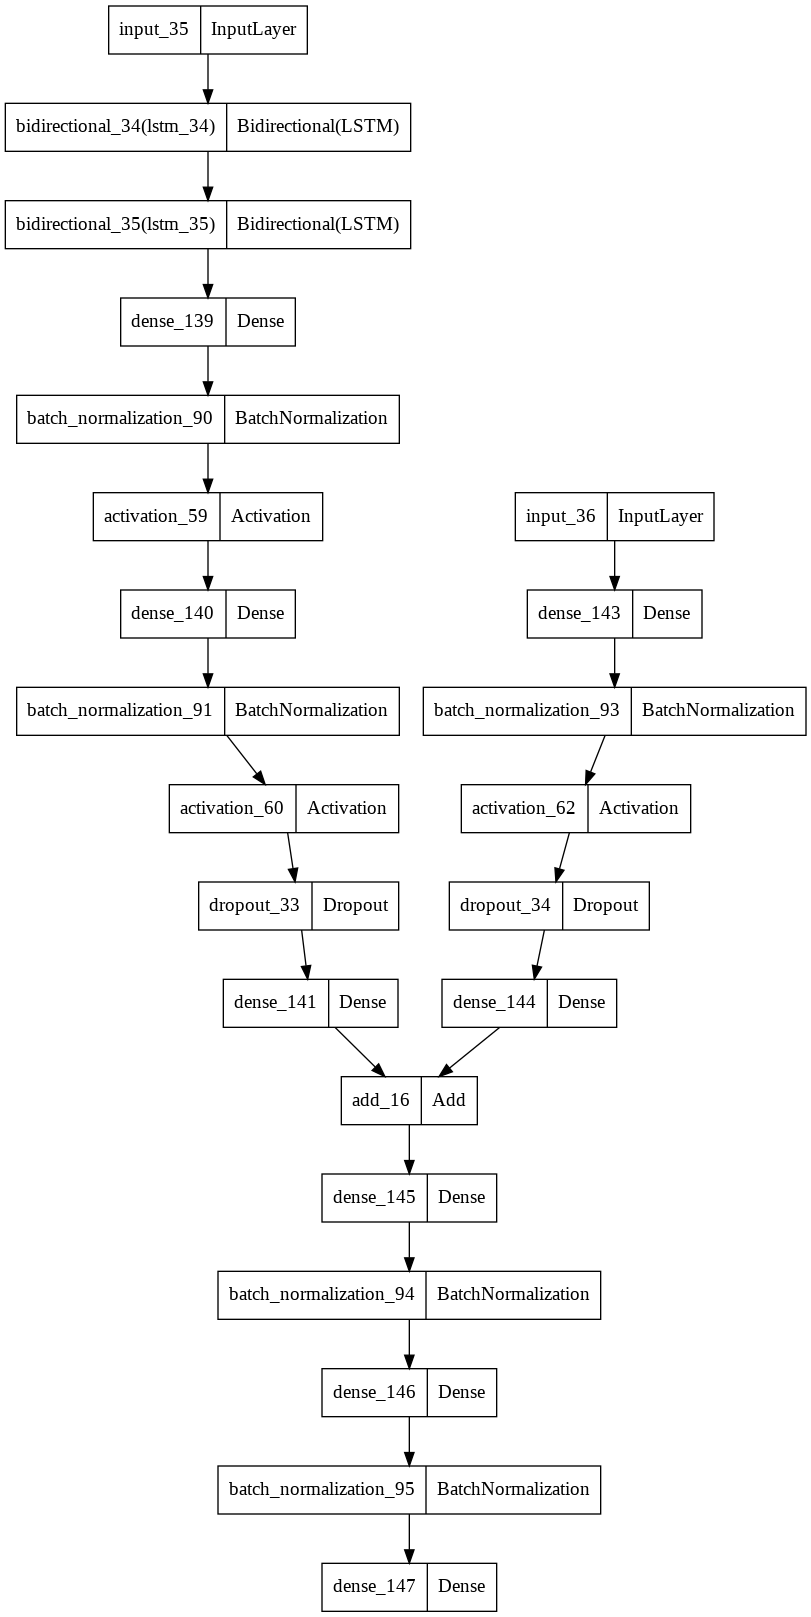

In [140]:
from keras.utils import plot_model
plot_model(model3, to_file='./model.png')

In [141]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=20),
            tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/sepsis_model_weight/lstm_model/lstm_model.{epoch:02d}-{val_auc:.3f}.h5',save_best_only=True)]
history_lstm3 = model3.fit(death_train_loader2,validation_data=death_test_loader2,
                    batch_size=32, epochs=500,callbacks=callback)

Epoch 1/500
405/405 [==============================] - 20s 21ms/step - loss: 0.4310 - auc: 0.6432 - val_loss: 0.4154 - val_auc: 0.6631
Epoch 2/500
405/405 [==============================] - 7s 17ms/step - loss: 0.3843 - auc: 0.7146 - val_loss: 0.3776 - val_auc: 0.7407
Epoch 3/500
405/405 [==============================] - 7s 17ms/step - loss: 0.3739 - auc: 0.7406 - val_loss: 0.3750 - val_auc: 0.7526
Epoch 4/500
405/405 [==============================] - 7s 17ms/step - loss: 0.3687 - auc: 0.7552 - val_loss: 0.3730 - val_auc: 0.7584
Epoch 5/500
405/405 [==============================] - 7s 17ms/step - loss: 0.3631 - auc: 0.7663 - val_loss: 0.3902 - val_auc: 0.7570
Epoch 6/500
405/405 [==============================] - 7s 18ms/step - loss: 0.3619 - auc: 0.7694 - val_loss: 0.3648 - val_auc: 0.7749
Epoch 7/500
405/405 [==============================] - 7s 17ms/step - loss: 0.3587 - auc: 0.7726 - val_loss: 0.3702 - val_auc: 0.7710
Epoch 8/500
405/405 [==============================] - 7s 17m

KeyboardInterrupt: ignored

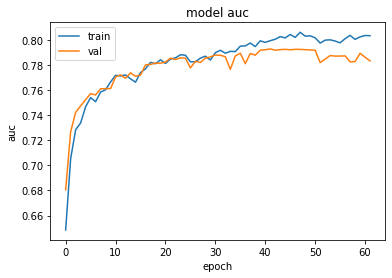

In [142]:
plt.plot(history_lstm3.history['auc'])
plt.plot(history_lstm3.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Trainset, Testset에 대한 ROC 커브 그리고 Confusion Matrix 구해보기
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, confusion_matrix

%matplotlib inline
lstm_train_predicts, lstm_test_predicts = list(), list()
lstm_train_labels, lstm_test_labels = list(), list()

for tr_x, tr_y in death_train_loader:
  batch_predict = death_lstm.predict(tr_x)
  lstm_train_predicts.append(batch_predict)
  lstm_train_labels.append(tr_y)

  batch_predict = death_trans.predict(tr_x)
  trans_train_predicts.append(batch_predict)
  trans_train_labels.append(tr_y)

for test_x, test_y in death_test_loader:
  batch_predict = death_lstm.predict(test_x)
  lstm_test_predicts.append(batch_predict)
  lstm_test_labels.append(test_y)

  batch_predict = death_trans.predict(test_x)
  trans_test_predicts.append(batch_predict)
  trans_test_labels.append(test_y)

lstm_train_predicts = np.concatenate(lstm_train_predicts).reshape(-1, 1)
lstm_train_labels = np.concatenate(lstm_train_labels).astype('int')
lstm_test_predicts = np.concatenate(lstm_test_predicts).reshape(-1, 1)
lstm_test_labels = np.concatenate(lstm_test_labels).astype('int')

trans_train_predicts = np.concatenate(trans_train_predicts).reshape(-1, 1)
trans_train_labels = np.concatenate(trans_train_labels).astype('int')
trans_test_predicts = np.concatenate(trans_test_predicts).reshape(-1, 1)
trans_test_labels = np.concatenate(trans_test_labels).astype('int')


trans_train_roc_x, trans_train_roc_y, _ = roc_curve(trans_train_labels, trans_train_predicts)
trans_train_auroc = roc_auc_score(trans_train_labels, trans_train_predicts)
trans_test_roc_x, trans_test_roc_y, _ = roc_curve(trans_test_labels, trans_test_predicts)
trans_test_auroc = roc_auc_score(trans_test_labels, trans_test_predicts)
# trans_train_roc_x, trans_train_roc_y, _ = roc_curve(trans_train_labels, trans_train_predicts)
# trans_train_auroc = roc_auc_score(trans_train_labels, trans_train_predicts)
# trans_test_roc_x, trans_test_roc_y, _ = roc_curve(trans_test_labels, trans_test_predicts)
# trans_test_auroc = roc_auc_score(trans_test_labels, trans_test_predicts)

lstm_train_roc_x, lstm_train_roc_y, _ = roc_curve(lstm_train_labels, lstm_train_predicts)
lstm_train_auroc = roc_auc_score(lstm_train_labels, lstm_train_predicts)
lstm_test_roc_x, lstm_test_roc_y, _ = roc_curve(lstm_test_labels, lstm_test_predicts)
lstm_test_auroc = roc_auc_score(lstm_test_labels, lstm_test_predicts)
# lstm_train_roc_x, lstm_train_roc_y, _ = roc_curve(lstm_train_labels, lstm_train_predicts)
# lstm_train_auroc = roc_auc_score(lstm_train_labels, lstm_train_predicts)
# lstm_test_roc_x, lstm_test_roc_y, _ = roc_curve(lstm_test_labels, lstm_test_predicts)
# lstm_test_auroc = roc_auc_score(lstm_test_labels, lstm_test_predicts)

plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')


plt.plot(lstm_train_roc_x, lstm_train_roc_y, linewidth=1.5, label='{} (AUROC={:.3f})'.format('LSTM Train', lstm_train_auroc))
plt.plot(lstm_test_roc_x, lstm_test_roc_y, linewidth=1.5, label='{} (AUROC={:.3f})'.format('LSTM Test', lstm_test_auroc))

plt.legend(fancybox=True)

plt.show()

In [ ]:
from keras import backend as k
k.clear_session()

In [ ]:
sum(death_train['LABEL'])/len(death_train['LABEL'])

모델 저장과
test data로 test( 5개 모델간 차이가 있는지)